In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.sim_drifter as sdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster


In [4]:
client

Client Scheduler: tcp://10.148.1.82:43682 Dashboard: http://10.148.1.82:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
dr = sdr.drifter_dataframe(root_path+run, tdir_max=1)

In [7]:
# Definition parameters
t0 = 1550 #initial time
t1 = 1590 # final time
tmid = (t0+t1)/2 # mid period
flt_id = 225 # test drifter id

#### Functions to compute initial, final, maximal and minimal latitudes for each drifters over a period of time

In [8]:
def latitudes_processing(df, myfun, tmin,tmax):
    ''' Compute maximal, minimal, initial and final latitudes for each drfiters over a period of time
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        myfun : func
            Method that will be applied to each window
            
        tmin : float
            initial time of the time window to observe
        tmax : float
            final time of the time window to observe
    Returns
    ----------
        out : pandas dataframe
            dataframe with maximal, minimal, initial and final latitudes over a period of time (with the drifters id in index)
    
    '''
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name
    p = df.sort_values('time').set_index('time')
    _p = p.loc[tmin:tmax]
    if _p.size==0:
        out = pd.DataFrame(data = np.full((1,4),np.nan),
                           columns=['latmax','latmin','lat0','lat1'],
                           index=p.id.unique())
    else:
    # need to create an empty dataframe, in case the loop below is empty
    #latmax,latmin,lat0,lat1 = myfun(_p) # get index from fake output
        myfun_out = myfun(_p,_p.index.min(),_p.index.max())
        index = list(myfun_out.index)
        out = pd.DataFrame(data = [list(myfun_out)],
                           columns=index,
                           index=_p.id.unique())#{'latmax':[myfun_out[0]],'latmin':[myfun_out[1]],'lati':[myfun_out[2]],'latf':[myfun_out[3]]},index = df.id.unique())
#[list(myfun_out)])
    return out

def diags_dist(flt,t0,t1):
#    fltI = flt.sel(time=slice(Ti,Tf))
    return pd.Series([flt.y.max(),flt.y.min(),flt.y.loc[t0],flt.y.loc[t1]],index=['latmax','latmin','lat0','lat1'])#,fltI.v

#### test the function for one drifter (flt_id)

In [9]:
df0 = dr.df.groupby('id').get_group(flt_id).compute()

In [10]:
out = latitudes_processing(df0, diags_dist, t0,t1)
out

,latmax,latmin,lat0,lat1
225,2038.76488,1807.56144,1923.7182,1824.60528


#### Apply the function to each drifter : 

In [11]:
df_chunked = dr.df.groupby('id').apply(latitudes_processing, diags_dist, t0, t1)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [13]:
df_chunked.get_partition(0).compute()


,,latmax,latmin,lat0,lat1
id,,,,,
22,22,970.49940,824.09036,948.88316,966.17220
135,135,1700.17104,1279.37776,1359.77420,1494.37348
553,553,2258.10616,2088.78684,2182.74284,2088.78684
780,780,1894.61008,1521.19760,1652.67260,1522.43200
801,801,2040.71652,1637.65820,1675.39396,1978.68612
1344,1344,1486.28888,1085.61248,1296.37140,1085.70224
2251,2251,1646.28084,1218.49928,1218.49928,1458.96628
2627,2627,2150.84260,1996.92168,2062.42244,1997.19492
2640,2640,2076.15232,2009.21824,2012.98368,2035.02988


In [12]:
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'id'})
                                       )
              )

In [13]:
DF = df_chunked.compute()

In [14]:
DF.drop(columns=['id']).sort_values('id')

,latmax,latmin,lat0,lat1
id,,,,
1,NaN,NaN,NaN,NaN
2,681.76764,538.73688,655.03432,677.73968
3,683.46960,541.97908,664.12564,681.30776
4,686.11996,546.87480,673.07044,685.15108
5,691.45004,553.23872,683.05788,689.61604
...,...,...,...,...
8996,2402.29776,2216.88128,2400.61452,2274.28876
8997,2418.70808,2235.58824,2416.89400,2287.54548
8998,2446.06252,2317.50140,2443.41544,2384.45996


In [15]:
ds  = DF.drop(columns=['id']).sort_values('id').to_xarray()
ds['minmax_r'] = ds.latmax/ds.latmin
ds['if_r'] = ds.lat0/ds.lat1
ds

<xarray.Dataset>
Dimensions:   (id: 9000)
Coordinates:
  * id        (id) int64 1 2 3 4 5 6 7 8 ... 8994 8995 8996 8997 8998 8999 9000
Data variables:
    latmax    (id) float64 nan 681.8 683.5 ... 2.446e+03 2.465e+03 2.469e+03
    latmin    (id) float64 nan 538.7 542.0 ... 2.318e+03 2.375e+03 2.39e+03
    lat0      (id) float64 nan 655.0 664.1 ... 2.443e+03 2.459e+03 2.463e+03
    lat1      (id) float64 nan 677.7 681.3 ... 2.384e+03 2.431e+03 2.44e+03
    minmax_r  (id) float64 nan 1.265 1.261 1.255 ... 1.082 1.055 1.038 1.033
    if_r      (id) float64 nan 0.9665 0.9748 0.9824 ... 1.057 1.025 1.011 1.009

#### Latitudes extrema for each drifter over 40 days (time window used to compute energy spectra in previous work)

Text(0, 0.5, '$lat_{max}/lat_{min}$')

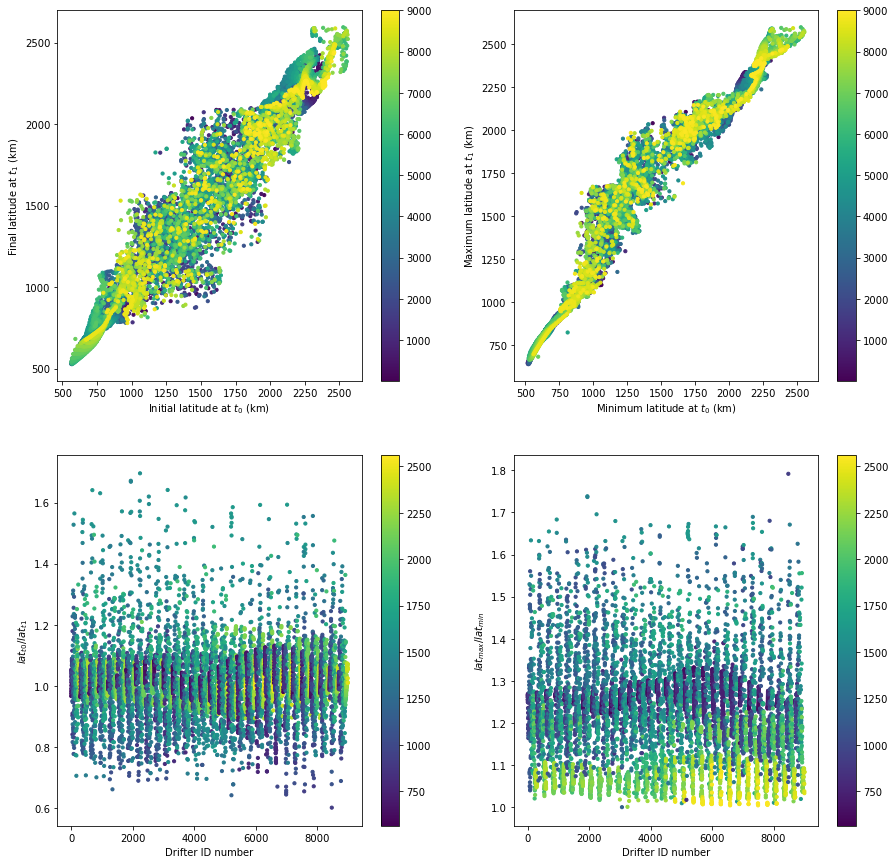

In [16]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,2,1)
cs = xr.plot.scatter(ds,'lat0','lat1',s=10,c=ds.id,ax=ax)
ax.set_xlabel('Initial latitude at $t_0$ (km)');ax.set_ylabel('Final latitude at $t_1$ (km)')
plt.colorbar(cs)
ax = fig.add_subplot(2,2,2)
cs = xr.plot.scatter(ds,'latmin','latmax',s=10,c=ds.id,ax=ax)
plt.colorbar(cs)
ax.set_xlabel('Minimum latitude at $t_0$ (km)');ax.set_ylabel('Maximum latitude at $t_1$ (km)')
ax = fig.add_subplot(2,2,3)
cs = xr.plot.scatter(ds,'id','if_r',s=10,c=ds.lat0,ax=ax)
plt.colorbar(cs)
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{t0}/lat_{t1}$')
ax = fig.add_subplot(2,2,4)
cs = xr.plot.scatter(ds,'id','minmax_r',s=10,c=ds.lat0,ax=ax)
plt.colorbar(cs)
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{max}/lat_{min}$')

#### Comments : 
We find a dependance between the covered latitudes (ratio between initial and final latitudes and maximal and minimal latitudes) and the initial latitude. At high latitudes (yellow and green/yellow points), the drifters don't seem to move a lot in latitudes, their max and min latitudes being quite close from each other over the observed period. For latitudes lower than $\simeq$ 1700km the min/max and inital/final latitudes seem to become significantly different.\
However the gap between the initial(lat0) and final (lat1) latitudes is not significant for the majority of the drifters. The ones that end up significantly away from their starting latitudes are part of those initially situated near or in the turbulent jet.\
So we have drifters that stay near their intial latitude all along their trajectory at high latitudes. At low latitudes, they present more variations of latitudes but with a coming back near their initial latitude (see if it is still the case for longer time period). And finally, near the jet, some drifters significantly northward or southward from their lat0.

#### Same than previously but over 100 days

In [17]:
df_chunked = dr.df.groupby('id').apply(latitudes_processing, diags_dist, 1500, 1600)
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'id'})
                                       )
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [18]:
DF = df_chunked.compute()

In [19]:
ds100  = DF.drop(columns=['id']).sort_values('id').to_xarray()
ds100['minmax_r'] = ds100.latmax/ds100.latmin
ds100['if_r'] = ds100.lat0/ds100.lat1

Text(0, 0.5, '$lat_{max}/lat_{min}$')

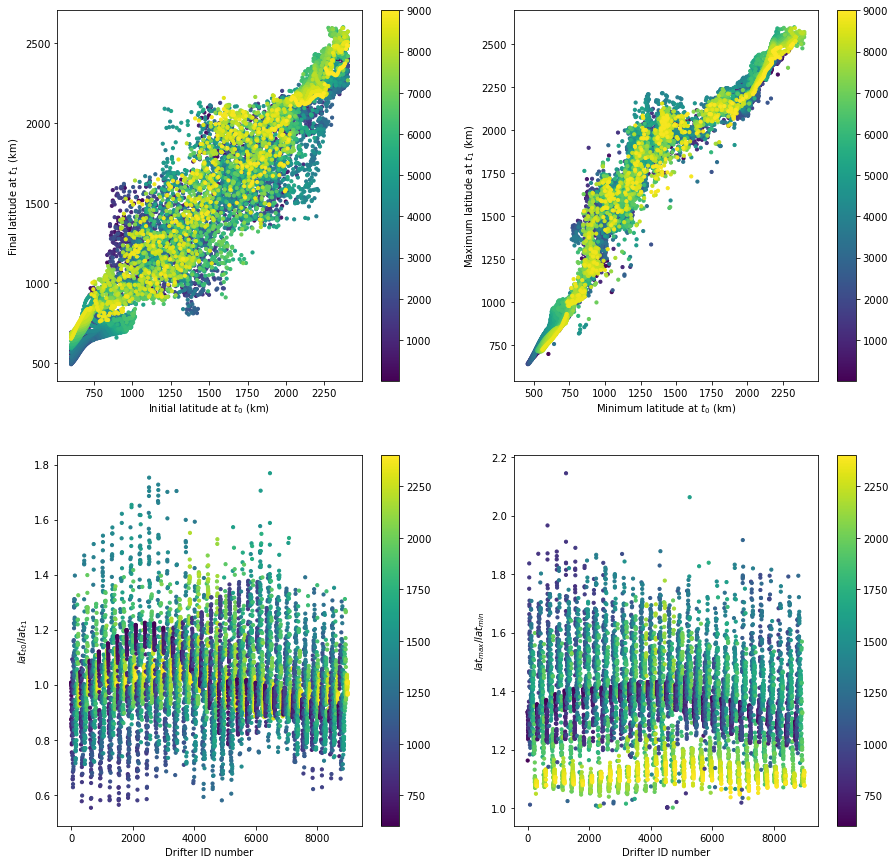

In [20]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,2,1)
cs = xr.plot.scatter(ds100,'lat0','lat1',s=10,c=ds100.id,ax=ax)
ax.set_xlabel('Initial latitude at $t_0$ (km)');ax.set_ylabel('Final latitude at $t_1$ (km)')
plt.colorbar(cs)
ax = fig.add_subplot(2,2,2)
cs = xr.plot.scatter(ds100,'latmin','latmax',s=10,c=ds100.id,ax=ax)
plt.colorbar(cs)
ax.set_xlabel('Minimum latitude at $t_0$ (km)');ax.set_ylabel('Maximum latitude at $t_1$ (km)')
ax = fig.add_subplot(2,2,3)
cs = xr.plot.scatter(ds100,'id','if_r',s=10,c=ds100.lat0,ax=ax)
plt.colorbar(cs)
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{t0}/lat_{t1}$')
ax = fig.add_subplot(2,2,4)
cs = xr.plot.scatter(ds100,'id','minmax_r',s=10,c=ds100.lat0,ax=ax)
plt.colorbar(cs)
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{max}/lat_{min}$')

Text(0.5, 0.98, 'Comparison between periods of 40 and 100 days')

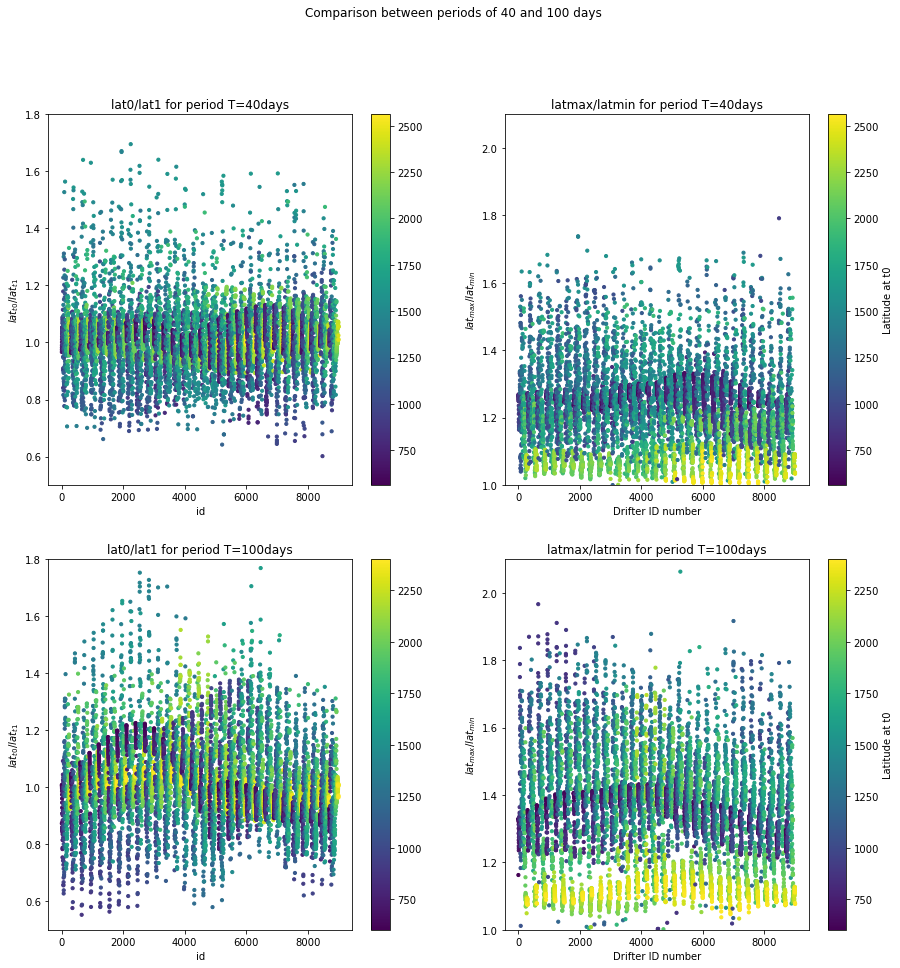

In [35]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,2,1)
cs = xr.plot.scatter(ds,'id','if_r',s=10,c=ds.lat0,ax=ax)
plt.colorbar(cs)
ax.set_ylim((0.5,1.8))
ax.set_ylabel(r'$lat_{t0}/lat_{t1}$')
ax.set_title('lat0/lat1 for period T=40days')
ax = fig.add_subplot(2,2,2)
cs = xr.plot.scatter(ds,'id','minmax_r',s=10,c=ds.lat0,ax=ax)
plt.colorbar(cs,label='Latitude at t0')
ax.set_ylim((1.0,2.1))
ax.set_title('latmax/latmin for period T=40days')
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{max}/lat_{min}$')
ax = fig.add_subplot(2,2,3)
cs = xr.plot.scatter(ds100,'id','if_r',s=10,c=ds100.lat0,ax=ax)
plt.colorbar(cs)
ax.set_ylim((0.5,1.8))
ax.set_ylabel(r'$lat_{t0}/lat_{t1}$')
ax.set_title('lat0/lat1 for period T=100days')
ax = fig.add_subplot(2,2,4)
cs = xr.plot.scatter(ds100,'id','minmax_r',s=10,c=ds100.lat0,ax=ax)
plt.colorbar(cs,label='Latitude at t0')
ax.set_ylim((1.0,2.1))
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{max}/lat_{min}$')
ax.set_title('latmax/latmin for period T=100days')
fig.suptitle('Comparison between periods of 40 and 100 days')

#### Comments:
For the longest time window (100 days), we still find than most of drifters move between close latitudes extrema at high latitudes (>2000km). At the lowest latitudes, the gap between min and max lat seem to increase for longer periods and the drifters seem to move further away from their initial position. Overall we observe more variations in latitudes extream and a growing number of drifters going significantly away from their starting latitude. More drifter from high latitudes are also moving southward from their lat0.\

###  The cells after this are just test and parts that could useful in the future but present on their own no interest.
### Number of drifters in (30x30) bins at t0

In [ ]:
dr.init_bins(y={'min':0, 'max': 2800, 'step': 30}, x={'min':0, 'max': 1000, 'step': 30})

In [10]:
df0 = dr.df.groupby('time').get_group(t0).compute()

In [15]:
df1 = dr.df.groupby('time').get_group(t1).compute()

In [17]:
flt0 = df0.sort_values('id').set_index('id')
flt1 = df1.sort_values('id').set_index('id')

In [28]:
count_bins0 = df0.groupby(['x_cut','y_cut'])['id'].agg('count').rename({'id': 'id_count'}).to_xarray()

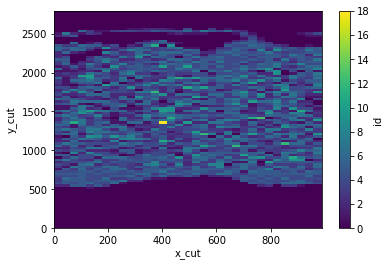

In [31]:
count_bins0.plot(y='y_cut')

### This part contains tests used in the previous part,this is just visualization of different trajectories and informations on those trajectories.

In [9]:
# tests on one drifter
flt1 = dr.df.groupby('id').get_group(flt_id).compute().sort_values('time').set_index('time')

In [10]:
# Informations on drifter trajectory:
flti = flt1.loc[t0:t1]
latmin,latmax, lat0,lat1, latmid = flti.y.min(),flti.y.max(), flt1.loc[t0].y, flt1.loc[t1].y, flt1.loc[tmid].y
#print('Minimum latitude : ',latmin,';  Maximum latitude : ',latmax,';  Latitude at t0 : ', lat0,
#      ';  Laitude at t1 : ', lat1';  Latitude at tmid : ',latmid)

#### Plot of latitude maximum, minimum and at mid period of one drifter

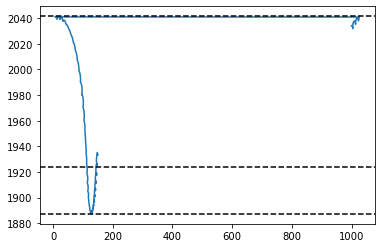

In [11]:
fig,ax  = plt.subplots()
ax.plot(flti.x,flti.y)
ax.axhline(y=latmax,c='k',linestyle='--')
ax.axhline(y=latmin,c='k',linestyle='--')
ax.axhline(y=latmid,c='k',linestyle='--')

#### Definition of the drifters postions at t0

In [13]:
df0 = dr.df.groupby('time').get_group(t0).compute().sort_values('y').set_index('y')

In [31]:
dr.init_bins(y={'min':0, 'max': 2800, 'step': 30}, x={'min':0, 'max': 1000, 'step': 30},
             time={'min':0, 'max': 1000, 'step': 1})

In [ ]:
dr.df.groupby(['id'])['y'].agg(['mean','min','max']).compute()#.loc[t0:t1]

In [ ]:
# Distance between inital drifter position (x0,y0) and position at time t (x,y)
def distance(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

In [ ]:
plt.plot(distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum())
distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum().shape

In [11]:
df0 = dr.df.groupby('time').get_group(flt1.index.min()).compute().sort_values('y').set_index('y')
#id0 = dr.df.groupby('time').get_group(flt1.index.min()).id

In [12]:
lat = [725,1215,1515,1715,2100]

In [13]:
DF0 = df0.to_xarray()#.sel(y=lat,method='nearest')

In [21]:
#DF0.sel(y=0,method='nearest')
yi = DF0.y[10::1800]
idi = DF0.id[10::1800]

In [ ]:
# Get several drifters
ds = {}
for i in idi[:2]:
    ds['flt_%s'%int(i.values)] = dr.df.groupby('id').get_group(int(i.values)).compute().sort_values('time').set_index('time').to_xarray()
ds

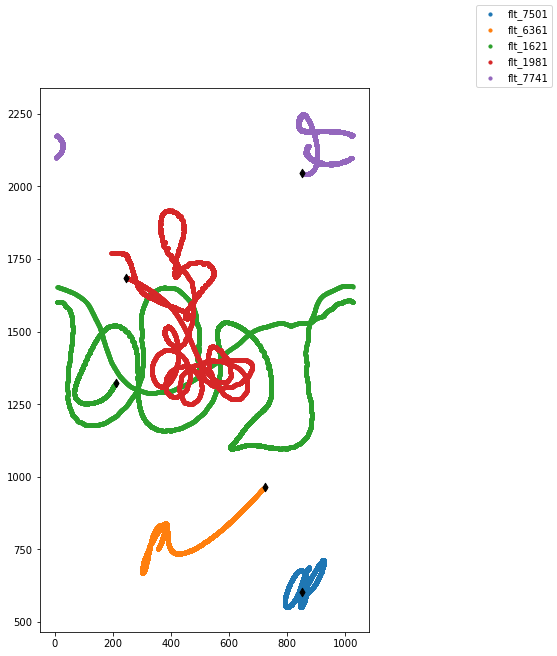

In [153]:
#Plot several drifters trajectories 
#(illustration of different trajectories depending on the initial latitude)
ti, tf = 1500,1600
fig,ax = plt.subplots(figsize=(10,10))
for d in ds :
    ax.scatter(ds['%s'%d].x.sel(time=slice(ti,tf)),ds['%s'%d].y.sel(time=slice(ti,tf)),
               s=10,label=str(d))
    ax.scatter(ds['%s'%d].x[0],ds['%s'%d].y[0],c='k',marker='d')
ax.set_aspect('equal')
fig.legend()

In [148]:
#Compute the latitudes for the chosen drifter(s) and wrap function to plot latitude max and min (dashed lines)
#and initial position (red point) (left figure) and dy/dt (v) (right figure)
def diags_dist(flt,Ti,Tf):
    fltI = flt.sel(time=slice(Ti,Tf))
    return fltI.y.max().values,fltI.y.min().values,fltI.y[0].values,fltI.y[-1].values,fltI.v
def plot_dist(flt,Ti,Tf,figsize):
    fltI = flt.sel(time=slice(Ti,Tf))
    latmax,latmin, lat0,lat1, dydt = diags_dist(flt,Ti,Tf)
    fig = plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,2,1)
    ax.plot(fltI.x,fltI.y)
    ax.axhline(y=latmax,c='k',linestyle='--')
    ax.axhline(y=latmin,c='k',linestyle='--')
    ax.scatter(fltI.x[0],fltI.y[0],c='r')
    ax.set_ylabel(r'${y_\rho}$ (km)');ax.set_xlabel(r'${x_\rho}$ (km)')
    ax = fig.add_subplot(1,2,2)
    ax.plot(fltI.time,dydt)
    ax.set_ylabel('dy/dt');ax.set_xlabel('Time (days)')

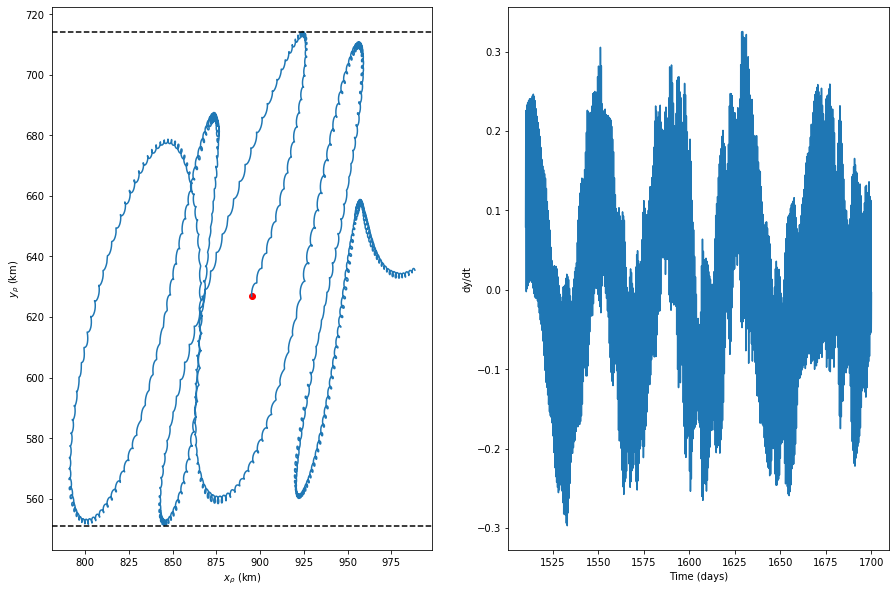

In [154]:
plot_dist(ds['flt_7501'],1510,1700,(15,10))

In [36]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
